In [1]:
# Install necessary packages if not already installed
!pip install pandas scikit-learn matplotlib seaborn transformers torch --quiet ipywidgets



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [18]:
#imports 
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import transformers

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nooria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:

url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
#print(df.head())


In [20]:
print(df.info())
print(df['label'].value_counts())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [26]:
# data cleaning

df['message'] = df['message'].str.lower()

df['message'] = df['message'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

df['message'] = df['message'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

stop_words = set(stopwords.words('english'))
df['message'] = df['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

print(df.head())


  label                                            message  label_num
0   ham  go jurong point crazy available bugis n great ...          0
1   ham                            ok lar joking wif u oni          0
2  spam  free entry wkly comp win fa cup final tkts st ...          1
3   ham                u dun say early hor u c already say          0
4   ham        nah dont think goes usf lives around though          0


In [22]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

X = df['message']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [24]:
# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

Logistic Regression Results:

              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.97      0.96      1115



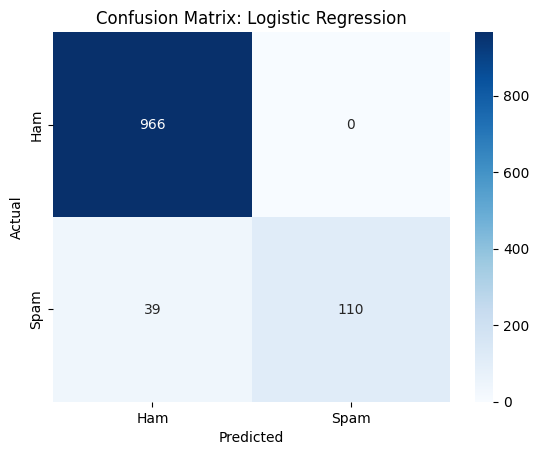

In [25]:
# Evaluation
print("Logistic Regression Results:\n")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.098500,0.054246
2,0.027700,0.063675


BERT Results:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.97      0.95      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



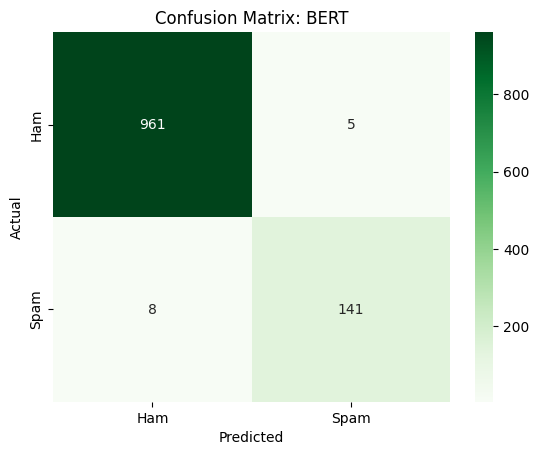

In [27]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Prepare datasets
train_dataset = SpamDataset(X_train, y_train, tokenizer)
test_dataset = SpamDataset(X_test, y_test, tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=10,
    disable_tqdm=False,
    logging_dir='./logs',
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Fine-tune BERT
trainer.train()

# Evaluate
preds = trainer.predict(test_dataset)
y_pred_bert = preds.predictions.argmax(axis=1)

print("BERT Results:\n")
print(classification_report(y_test, y_pred_bert))

# Confusion Matrix
cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix: BERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


0.9650224215246637 log regression
0.9883408071748879 bert


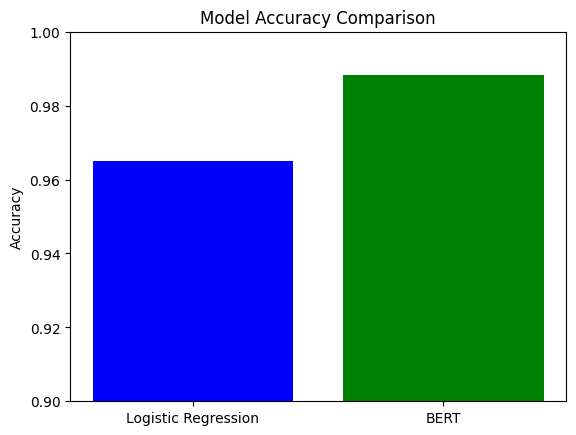

In [28]:
acc_logreg = accuracy_score(y_test, y_pred)
acc_bert = accuracy_score(y_test, y_pred_bert)

print(acc_logreg, 'log regression')
print(acc_bert, 'bert')

plt.bar(['Logistic Regression', 'BERT'], [acc_logreg, acc_bert], color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.9, 1.0)

# Save the plot before plt.show()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')  # Adjust filename/format as needed

plt.show()


In [29]:
#testing model performance
# Evaluate on training data
train_results = trainer.evaluate(train_dataset)
print("Train set results:", train_results)

# Evaluate on test data
test_results = trainer.evaluate(test_dataset)
print("Test set results:", test_results)

#from this we can conclude that training loss is close to test loss it suggests model performed good
#thus the model is not overfitted
# no hyperparameter tuning is required because model achieved acc of 99%. 

Train set results: {'eval_loss': 0.010268048383295536, 'eval_runtime': 10.822, 'eval_samples_per_second': 411.846, 'eval_steps_per_second': 6.468, 'epoch': 2.0}
Test set results: {'eval_loss': 0.06367479264736176, 'eval_runtime': 2.6302, 'eval_samples_per_second': 423.922, 'eval_steps_per_second': 6.844, 'epoch': 2.0}
